## Vornoi Binning Notebook

### Written by Celia Mulcahey

#### Email celia.mulcahey@gmail.com with any questions or concerns

#### History:

- 3/23/2022: Finished adapting master notebook to be interactive
- 4/27/2022: Edited comments to be clearer
- 10/11/2022: Changed a few variable names, made notebook less FRB focused. FRB version still exists though.

In [1]:
#Select galaxy to analyze
gal_name = "NGC1266" #YOUR INPUT (e.g. "FRB180924")
target_sn = 10 #YOUR INPUT, the target S/N used for voronoi binning

In [27]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit

from scipy.stats import norm
import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from astropy.stats import mad_std
import os
import datetime
from time import perf_counter as clock


def gauss(x, *p):
    return p[0]+p[1]*np.exp(-0.5*((x-p[2])/p[3])**2)

def double_gauss(x, *p):
    return p[0]+p[1]*np.exp(-0.5*((x-p[2])/p[3])**2)+p[4]*np.exp(-0.5*((x-p[5])/p[6])**2)

def triple_gauss(x, *p):
    return p[0]+p[1]*np.exp(-0.5*((x-p[2])/p[3])**2)+p[4]*np.exp(-0.5*((x-p[5])/p[6])**2)+p[7]*np.exp(-0.5*((x-p[8])/p[9])**2)

def slopeintfunc(x,sl,incpt):
    return sl*x+incpt

def rest_frame (red_shift, lambda_observed):
    '''This function calculates the rest wavelength of a shifted spectrum
        Arguments:
            red_shift - redshift of the system
            lamda_observed - array of shifted lambdas
        Returns:
            lambda_rest - array of lambdas at rest frame'''
    lambda_rest = lambda_observed/(red_shift+1)
    return lambda_rest

now = datetime.datetime.now()
root_dir = os.getcwd() 
in_dir = os.path.join(root_dir,'inputs')
out_dir = os.path.join(root_dir, 'outputs')
plot_dir = os.path.join(root_dir, 'plots')

if os.path.exists(os.path.join(out_dir, gal_name)+'/') == True:
    gal_out_dir = os.path.join(out_dir, gal_name)
    print('Output Directory: '+gal_out_dir)
    print()
    
else:
    gal_out_dir = os.mkdir(os.path.join(out_dir, gal_name+'/'))
    print("Directory " + gal_out_dir + " created")
    print()
    
if os.path.exists(os.path.join(plot_dir, gal_name)+'/') == True:
    gal_plot_dir = os.path.join(plot_dir, gal_name)
    print('Plot Directory: ' + gal_plot_dir)
    print()
else:
    gal_plot_dir = os.mkdir(os.path.join(plot_dir, gal_name+'/'))
    print("Directory " + gal_plot_dir + " created")
    print()
    
cube_dir = "/Users/jotter/highres_PSBs/ngc1266_data/MUSE/ADP.2019-02-25T15 20 26.375.fits"
code_dir = "/Users/jotter/highres_PSBs/ppxf/MILES_BASTI_CH_baseFe/"
            # YOUR INPUT, directory where stellar templates
           # are located (e.g. '/Users/ceilm/Anaconda3/Lib/site-packages/ppxf/miles_models/')

voronoi_list_file = gal_name+'_voronoi_list_{}{}{}.txt'.format(now.year, now.strftime("%b"), now.day)
voronoi_bin_file = gal_name+'_voronoi_output_targetSN_{}_{}{}{}.txt'.format(str(target_sn), now.year, now.strftime("%b"), now.day)

#gal = gal.FRB.by_name(frb_name)
#FRBpos = FRB.coord
#HGpos = FRB.grab_host().coord

c = 299792.458
z = 0.007214 # YOUR INPUT, redshift of galaxy, from SIMBAD

Output Directory: /Users/jotter/highres_PSBs/ngc1266/muse_data/MAP_interactive/outputs/NGC1266

Plot Directory: /Users/jotter/highres_PSBs/ngc1266/muse_data/MAP_interactive/plots/NGC1266



In [26]:
hdu = fits.open(cube_dir)

Hdr0 = hdu[0].header
#obtaining data 
data = hdu[1].data
#obtaining error
error = hdu[2].data

#get wavelength from header
hdr1 = hdu[1].header
#hdr1
#number of pixels
npix = hdr1['NAXIS3']
#starting wavelength
lam_start = hdr1['CRVAL3']
#wavelength step
d_lam = hdr1['CD3_3']


wl = lam_start
wl_array = []

for x in range (0, npix):
    wl_array.append(wl)    
    wl = wl+d_lam
    
wl_array=np.array(wl_array)
shifted_wavelengths = rest_frame(z, wl_array)

In [9]:
# Defining the wavelengths of all the continuum. 

# Using the range 4150 – 4350 Å, following Guérou et al. 2017 (IDEAL RANGE FOR galaxies at redshift 0.2 ≲ z ≲ 0.8)
# https://ui.adsabs.harvard.edu/abs/2017A%26A...608A...5G/abstract
# AT LOWER REDSHIFTS, YOU COULD USE CaT or Mgb, etc.


# You might not want to use this wavelength range, especially if there is a strong skyline that would affect the 
# S/N estimates

#lo_lam, hi_lam = 4150*(1+z), 4350*(1+z) # these values may change depending on the quality of your data

lo_lam, hi_lam = 5000*(1+z), 5200*(1+z)

#x_pixel = int(INPUT NUMBER) # central x pixel of galaxy, look in qfits view, the center of the galaxy may not be in 
                            # the center of the cube.
#y_pixel = int(INPUT NUMBER) # central y pixel of galaxy.

# Alternatively, if the galaxy ~is~ in the center of the cube, uncomment these lines and comment the two above
x_pixel = int(hdr1['NAXIS1']/2) # center x pixel
y_pixel = int(hdr1['NAXIS2']/2) # center y pixel

spectrum = data[:,y_pixel,x_pixel]
subIndices0 = np.where((shifted_wavelengths>=lo_lam) & (shifted_wavelengths<=hi_lam))
subSpec0 = np.array((shifted_wavelengths[subIndices0],spectrum[subIndices0]))
fit = curve_fit(slopeintfunc, subSpec0[0],subSpec0[1])
residuals = subSpec0[1]-slopeintfunc(subSpec0[0],fit[0][0],fit[0][1])

Text(0, 0.5, 'Flux')

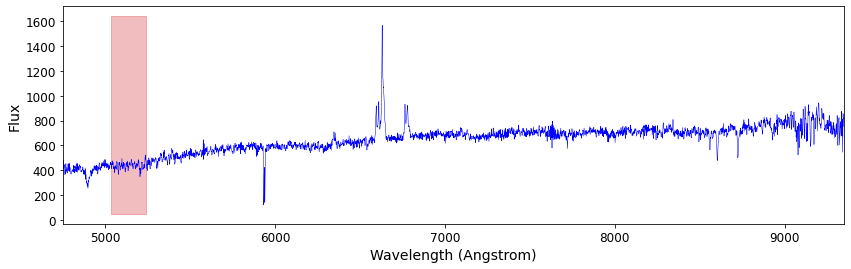

In [19]:
# Plotting the spectrum, just to take a look. Feel free to add x & y limits to check out
# different portions of the continuum
fig, ax = plt.subplots(figsize = (14,4))
plt.plot(wl_array, spectrum, 'b', lw = 0.5)
ylim = plt.ylim()
plt.fill_betweenx(ylim, [lo_lam, lo_lam], [hi_lam, hi_lam], alpha=0.3, color='tab:red')

plt.xlim(wl_array[0], wl_array[-1])
plt.tick_params(labelsize=12)
plt.xlabel("Wavelength (Angstrom)", fontsize=14)
plt.ylabel("Flux", fontsize=14)

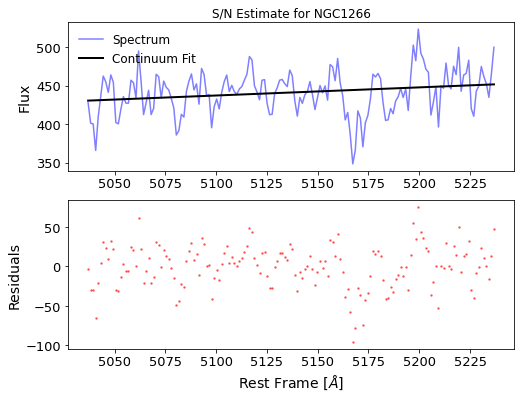

In [28]:
noise = mad_std(residuals)
signal = np.nanmedian(slopeintfunc(subSpec0[0],fit[0][0],fit[0][1]))
plt.figure(figsize = (8,6))

plt.subplot(2,1,1)
plt.plot(subSpec0[0],subSpec0[1], 'b', lw = 1.5, alpha = 0.5, label = 'Spectrum')
plt.plot(subSpec0[0], slopeintfunc(subSpec0[0], fit[0][0], fit[0][1]), color="k", lw = 2, label = 'Continuum Fit')

plt.ylabel(r'Flux',fontsize=14)

plt.title('S/N Estimate for '+gal_name)

#plt.text(5000, 2000, 'Estimated S/N = '+str(np.round(signal/noise,3)),fontsize = 12.5)
#plt.ylim(INPUT Y MIN, INPUT Y MAX)
    
plt.tick_params(labelsize=13)
plt.legend(frameon = False, loc = 'upper left', fontsize = 'large')

plt.subplot(2,1,2)
plt.errorbar(subSpec0[0],residuals,fmt='r.', alpha = 0.5, ms = 3)
plt.tick_params(labelsize=13)
plt.ylabel('Residuals', fontsize = 14)
plt.xlabel(r'Rest Frame [$\AA$]',fontsize=14)

plt.savefig(os.path.join(gal_plot_dir,gal_name+'_sn_estimate.png'),dpi = 300)

In [40]:
voronoi_list=[]

# In this cell, loop through the x and y pixels of cube, determine the S/N values were by fitting the continuum region,
# I've given the bare bones for ease, refer to the fourth cell for help too :)

for x in range(data[0,0,:].shape[0]):
    for y in range(data[0,:,0].shape[0]):
        
        spectrum = data[:,y,x]
        subIndices0 = np.where((shifted_wavelengths>=lo_lam) & (shifted_wavelengths<=hi_lam))
        nonan_ind = np.where(np.isnan(spectrum[subIndices0])==False)[0]
        subSpec0 = np.array((shifted_wavelengths[subIndices0][nonan_ind],
                             spectrum[subIndices0][nonan_ind]))
        
        if len(subSpec0[0]) < 10:
            voronoi_list.append([x,y,np.nan,np.nan])
            #print('only nans')
        else:
            fit = curve_fit(slopeintfunc, subSpec0[0],subSpec0[1])
            residuals = subSpec0[1]-slopeintfunc(subSpec0[0],fit[0][0],fit[0][1])
            noise = mad_std(residuals)
            signal = np.nanmedian(slopeintfunc(subSpec0[0],fit[0][0],fit[0][1]))


            voronoi_list.append([x,y,signal,noise])
        
np.savetxt(os.path.join(gal_out_dir,voronoi_list_file),voronoi_list)
print('Saved Voronoi List to: ', gal_out_dir+"/"+voronoi_list_file)

Saved Voronoi List to:  /Users/jotter/highres_PSBs/ngc1266/muse_data/MAP_interactive/outputs/NGC1266/NGC1266_voronoi_list_2022Oct18.txt


In [65]:
x, y, signal, noise = np.loadtxt(os.path.join(gal_out_dir, voronoi_list_file)).T

Text(0, 0.5, 'Pixel')

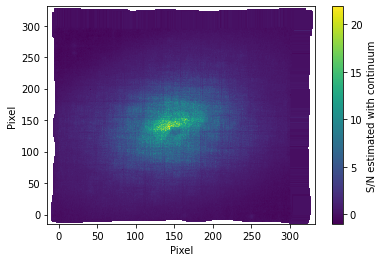

In [42]:
# Making a 2D histogram, 'spatially resolving' the S/N estimates
# Highest S/N should be in the center of the galaxy
plt.scatter(x,y,marker='s',s=300,c=signal/noise)
plt.colorbar(label = 'S/N estimated with continuum')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
#plt.xlim(0,19)
#plt.ylim(0,19)

In [54]:
nonan_ind = np.where(np.isnan(signal) == False)[0]
signal_nonan = signal[nonan_ind]
noise_nonan = noise[nonan_ind]
x_nonan = x[nonan_ind]
y_nonan = y[nonan_ind]

bin_num, x_gen, y_gen, xbin, ybin, sn, nPixels, scale = voronoi_2d_binning(x_nonan, y_nonan, signal_nonan, noise_nonan,
                                                                           target_sn, plot=0, quiet=1, pixelsize=0.2)

/Users/jotter/opt/anaconda3/lib/python3.9/site-packages/vorbin/voronoi_2d_binning.py:277: RuntimeWarning: invalid value encountered in sqrt
  scale[k] = np.sqrt(index.size/sn)  # Eq. (4) of Diehl & Statler (2006)


In [72]:
# THIS CELL ONLY NEEDS TO BE RUN ONCE, COMMENT OUT AFTER RUNNING IT 

# In the line below, use the voronoi binning calling sequence to perform adaptive spatial binning. 
# Check out the calling sequence on https://pypi.org/project/vorbin/ for an example 
# Note this cell will return an error if you do not add the calling sequence because binNum will not yet be defined.

# Save out the binning info

bin_num_full = np.repeat(-1, len(signal))
bin_num_full[nonan_ind] = bin_num
np.savetxt(os.path.join(gal_out_dir,voronoi_bin_file), np.column_stack([x, y, bin_num_full]),
             fmt=b'%8i %8i %8i')

[2003 2003 2003 ... 3629 3629 3629]


In [74]:
#Read in voronoi binning txt file
x,y,binNum = np.loadtxt(os.path.join(gal_out_dir,voronoi_bin_file)).T
x,y,binNum = x.astype(int), y.astype(int), binNum.astype(int)
print('Number of unique bins: ', len(np.unique(binNum)))
print(binNum)

Number of unique bins:  3632
[-1 -1 -1 ... -1 -1 -1]


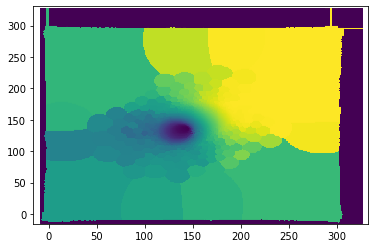

In [78]:
n_specs = []

for bn in np.unique(binNum):
    b_loc = np.where(binNum == bn)[0]
    x_loc = x[b_loc]
    y_loc = y[b_loc]
    spectra = data[:,y_loc,x_loc]
    n_spec = spectra.shape[1] 
    n_specs.append(n_spec)

# Plotting the number of spectra in each bin, center bins should be 1-2 pixels in size (1-2 spectra), and get
# progressively larger as it moves to the outskirts.

plt.scatter(x,y,marker='s',s=300,c=bin_num_full)

#vb = display_bins(x, y, binNum, np.array(n_specs), pixelsize = 1)